# Gelogical Image Similarity
**This is a personal ML project on [Geological Image Similarity Dataset](https://www.kaggle.com/tanyadayanand/geological-image-similarity)**  

### BACKGROUND
A geology research company wants to create a tool for identifying interesting patterns in their imagery data. This tool
will possess a search capability whereby an analyst provides an image of interest and is presented with other images
which are similar to it.

### GOAL
Task is to create the machine learning component for this image similarity application. The machine learning
model should return the top K images that are most similar to this image based on a single image input.

### ABOUT the DATA:
The data includes 6 different classes of 5000 28X28 RGB images (total of 29998 images)

In [1]:
# Load usefull libraries and helper functions
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import random

from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

from sklearn.metrics.pairwise import cosine_similarity

## Load Files

In [21]:
# Initial files are in r'input\raw' directory
root_dir = r'input\raw'

# Dataset consists of 6 folders each containing around 5k photographs
subfolders = [f.path for f in os.scandir(root_dir) if f.is_dir()]
for subfolder in subfolders:
    print(subfolder.split('\\')[-1], ':', len(os.listdir(subfolder)), 'images')

# Get all filenames in folder: 
img_files = [os.path.join(path, name) for path, subdirs, files in os.walk(root_dir) for name in files]
print('dataset length = ', len(img_files))
print('First 5 files:', img_files[0:5])

andesite : 5000 images
gneiss : 5000 images
marble : 4998 images
quartzite : 5000 images
rhyolite : 5000 images
schist : 5000 images
dataset length =  29998
First 5 files: ['input\\raw\\andesite\\012L6.jpg', 'input\\raw\\andesite\\01ITR.jpg', 'input\\raw\\andesite\\01LQQ.jpg', 'input\\raw\\andesite\\0230P.jpg', 'input\\raw\\andesite\\02741.jpg']


## Create Train-Test Split

In [3]:
# Let's create train and test directories
try:
    os.mkdir(r'input\train')
    os.mkdir(r'input\train\andesite')
    os.mkdir(r'input\train\gneiss')
    os.mkdir(r'input\train\marble')
    os.mkdir(r'input\train\quartzite')
    os.mkdir(r'input\train\rhyolite')
    os.mkdir(r'input\train\schist')

    os.mkdir(r'input\test')
    os.mkdir(r'input\test\andesite')
    os.mkdir(r'input\test\gneiss')
    os.mkdir(r'input\test\marble')
    os.mkdir(r'input\test\quartzite')
    os.mkdir(r'input\test\rhyolite')
    os.mkdir(r'input\test\schist')
    
    # Copy the files from initial directory to train and test
    # Shuffle the list inplace
    random.seed(42)
    random.shuffle(img_files)
    print('5 first shuffled images:', img_files[0:5])

    # We use 90% of data for train and 10% for test
    train = img_files[:27000]
    for f in train:
        subfolder = f.split('\\')[2]
        folder = 'input\\train' + '\\' + subfolder
        shutil.copy(f, folder)

    test = img_files[27000:]
    for f in test:
        subfolder = f.split('\\')[2]
        folder = 'input\\test' + '\\' + subfolder
        shutil.copy(f, folder)  
except: pass

In [4]:
# Resulting files with unstratified split still show good class-balance
directory = 'input\\train'
subfolders = [f.path for f in os.scandir(directory) if f.is_dir()]
for subfolder in subfolders:
    print(subfolder.split('\\')[1], ':', len(os.listdir(subfolder)), 'images')

directory = 'input\\test'
subfolders = [f.path for f in os.scandir(directory) if f.is_dir()]
for subfolder in subfolders:
    print(subfolder.split('\\')[1], ':', len(os.listdir(subfolder)), 'images')

train : 4506 images
train : 4517 images
train : 4479 images
train : 4507 images
train : 4488 images
train : 4503 images
test : 494 images
test : 483 images
test : 519 images
test : 493 images
test : 512 images
test : 497 images


## Preview the Images

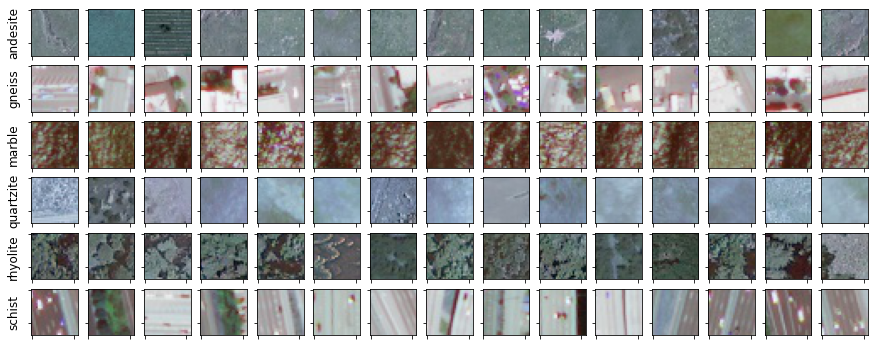

In [5]:
# Let's preview some randomly selected images of each class
n_show = 15

directory = 'input\\raw'
subfolders = [f.path for f in os.scandir(directory) if f.is_dir()]

fig, axes = plt.subplots(len(subfolders), n_show, figsize = (n_show,6))
# Preview images:
for row_idx, subfolder in enumerate(subfolders):    
    filenames = [f.path for f in os.scandir(subfolder)]   
    files_to_preview = random.sample(filenames, n_show)
    for col_idx, path in enumerate(files_to_preview):
        image = mpimg.imread(path)
        axes[row_idx, col_idx].imshow(image)
        axes[row_idx, col_idx].set_xticklabels([])
        axes[row_idx, col_idx].set_yticklabels([])

# Set labels:
for ax, row in zip(axes[:,0], subfolders):
    ax.set_ylabel(row.split('\\')[2], rotation=90, size='large')

plt.show()

## Create PyTorch Dataset from the Data

In [6]:
# Let's transform our dataset to torch datasets:

class GeologicalDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform # what transforms were passed to the initialiser
        
        img_names_list = [os.path.join(path, name) for path, subdirs, files in os.walk(root_dir) for name in files]
        
        label_to_idx = {
            'andesite': 0,
            'gneiss': 1,
            'marble': 2,
            'quartzite': 3,
            'rhyolite': 4,
            'schist': 5
            }

        labels_list = [label_to_idx[os.path.join(path, name).split('\\')[-2]] for path, subdirs, files in os.walk(root_dir) for name in files]
        
        # randomise images
        self.img_names, self.labels = shuffle(img_names_list, labels_list)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):        
        image = mpimg.imread(self.img_names[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        return image, label

## Create Transforms for Train and Test

In [7]:
# Create transforms for train and test
    # All data transformed to Tensor and Normalized (for each channel) - see the parameters in the next cell
    # random horizontal and vertical flips used for train

train_transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    #transforms.RandomRotation(degrees=(0,360)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5080, 0.5196, 0.5195],
                         std=[0.1852, 0.1995, 0.2193])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5080, 0.5196, 0.5195],
                         std=[0.1852, 0.1995, 0.2193])
])

train_set = GeologicalDataset('input\\train',transform=train_transform)
test_set = GeologicalDataset('input\\test',transform=test_transform)

print('train_set:', len(train_set))
print('test_set:', len(test_set))

train_set: 27000
test_set: 2998


## Create CNN Architecture
### Output for the penultimate layer (embedding) is also provided as output

In [8]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.nn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(in_features=2304, out_features=512),
            nn.Dropout2d(0.25),
            nn.Linear(in_features=512, out_features=128),
            )

        self.linear = nn.Linear(in_features=128, out_features=6)
        
    def forward(self, x):
        embedding = self.nn(x)
        x = self.linear(embedding)
        return embedding, x
        
model = CNN()
print(model)

CNN(
  (nn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten()
    (9): Linear(in_features=2304, out_features=512, bias=True)
    (10): Dropout2d(p=0.25, inplace=False)
    (11): Linear(in_features=512, out_features=128, bias=True)
  )
  (linear): Linear(in_features=128, out_features=6, bias=True)
)


## Instantiate the Model and Load Last Training Weights

In [9]:
model = CNN()

try: model.load_state_dict(torch.load('model_state_dict.pth'))
except: pass

loss_func = nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

batch_size = 1024

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=5000)

## Train

In [10]:
%%time
# Train the model

loss_list = []
train_accuracy_list = []
test_accuracy_list = []
                                    
num_epochs = 30

for epoch in range(num_epochs):
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        _, outputs = model(images)
        predictions = torch.max(outputs, 1)[1]
        train_accuracy = accuracy_score(predictions, labels)
        train_accuracy_list.append(train_accuracy)
        loss = loss_func(outputs, labels)                
        loss.backward()        
        optimizer.step()
        loss_list.append(loss)
        
    # At the end of epoch - evaluate test set accuracy
    for images, labels in test_loader:
        model.eval()
        _, outputs = model(images)
        predictions = torch.max(outputs, 1)[1]
        test_accuracy = accuracy_score(predictions, labels)
        test_accuracy_list.append(test_accuracy)
    
    print('Epoch: ', epoch, '  Train accuracy:', round(train_accuracy,4), '  Test accuracy:', round(np.mean(test_accuracy),4))

# Save the trained weights of the model
torch.save(model.state_dict(), 'model_state_dict.pth')

Epoch:  0 Train accuracy: 0.9309     Test accuracy: 0.8319
Epoch:  1 Train accuracy: 0.9468     Test accuracy: 0.953
Epoch:  2 Train accuracy: 0.9441     Test accuracy: 0.9623
Epoch:  3 Train accuracy: 0.9495     Test accuracy: 0.9656
Epoch:  4 Train accuracy: 0.9628     Test accuracy: 0.968
Epoch:  5 Train accuracy: 0.9628     Test accuracy: 0.9723
Epoch:  6 Train accuracy: 0.9654     Test accuracy: 0.974
Epoch:  7 Train accuracy: 0.9628     Test accuracy: 0.955
Epoch:  8 Train accuracy: 0.9707     Test accuracy: 0.977
Epoch:  9 Train accuracy: 0.9761     Test accuracy: 0.9753
Epoch:  10 Train accuracy: 0.9761     Test accuracy: 0.979
Epoch:  11 Train accuracy: 0.9761     Test accuracy: 0.978
Epoch:  12 Train accuracy: 0.9761     Test accuracy: 0.9783
Epoch:  13 Train accuracy: 0.9814     Test accuracy: 0.979
Epoch:  14 Train accuracy: 0.9814     Test accuracy: 0.9797
Epoch:  15 Train accuracy: 0.984     Test accuracy: 0.984
Epoch:  16 Train accuracy: 0.9814     Test accuracy: 0.9833


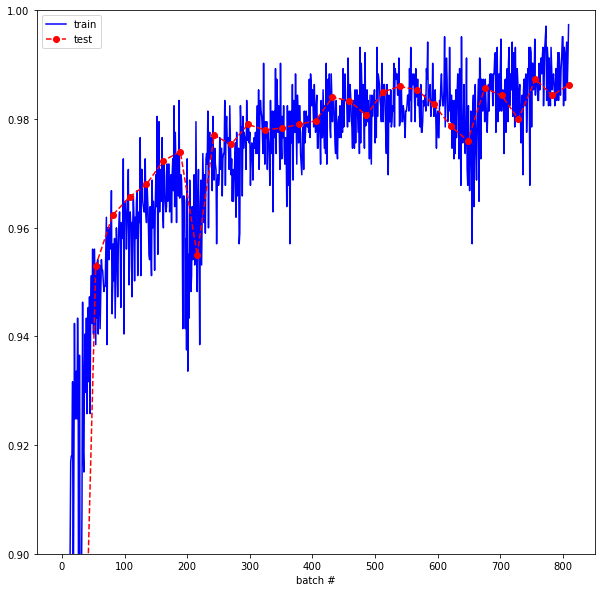

In [11]:
#Plot Train and Test Accuracy Results
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(list(range(len(train_accuracy_list))), train_accuracy_list, 'b', label='train')
plt.plot((np.array(list(range(len(test_accuracy_list))))+1)*27, test_accuracy_list, '--ro', label='test')
plt.ylim([0.9,1])
plt.xlabel('batch #')
plt.legend()
plt.show()

## Embeddings

In [12]:
def get_embedding(file, model):
    image = mpimg.imread(file)
    image = test_transform(image)
    image = image.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        emb, _ = model(image)
    return emb.numpy()

## Calculate Embeddings for Train Images

In [13]:
%%time
# Get embeddings for train data
train_dir = 'input\\train'
img_files_train = [os.path.join(path, name) for path, subdirs, files in os.walk(train_dir) for name in files]

train_emb = np.zeros((len(img_files_train), 128))
for idx, file in enumerate(img_files_train):
    train_emb[idx] = get_embedding(file, model=model)
print(train_emb.shape)

(27000, 128)
Wall time: 1min 26s


## Select Random Test Image

input\test\rhyolite\2GE4A.jpg


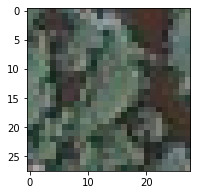

In [22]:
# Select random image from test
test_dir = 'input\\test'
img_files_test = [os.path.join(path, name) for path, subdirs, files in os.walk(test_dir) for name in files]
random_file = random.choice(img_files_test)

# Get the embedding for this image
emb = get_embedding(random_file, model=model)

print(random_file)
plt.rcParams["figure.figsize"] = (3,3)
image = mpimg.imread(random_file)
plt.imshow(image)
plt.show()

## Calculate Similarities Between the Selected Image and Train Images 

In [23]:
similarities = cosine_similarity(emb, train_emb)

## Preview K-Most Similar Images from Train Data 

input\train\rhyolite\6DMV3.jpg


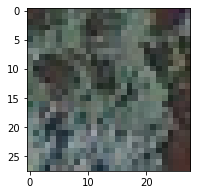

input\train\rhyolite\KAW4Q.jpg


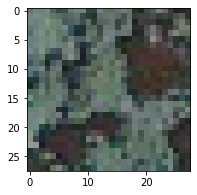

input\train\rhyolite\HY7WI.jpg


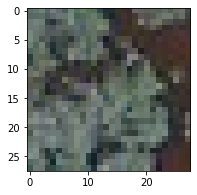

input\train\rhyolite\V4AUO.jpg


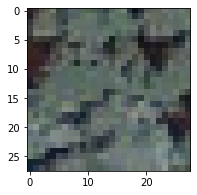

input\train\rhyolite\XPB3Y.jpg


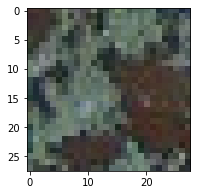

In [25]:
# Select top n-similar file indeces
K=5
ids = np.flip(similarities.argsort()[0])[0:K]

for index in ids:
    image = img_files_train[index]
    print(image)
    image = mpimg.imread(image)
    plt.imshow(image)
    plt.show()